# Full Correlation Matrix Analysis (FCMA) demo 
By Peeta Li ([peetal@uoregon.edu](mailto:peetal@uoregon.edu)), Yida Wang ([yidawa@gmail.com](mailto:yidawa@gmail.com)) and Ben Hutchinson ([bhutch@uoregon.edu](mailto:bhutch@uoregon.edu))

## Overview
- Given an experimental deisgn that consists of two conditions (A and B), we can ask whether the functional connectivity (FC) between brain regions differs across conditions. Traditional FC analyses employ a seed based approach, which can be biased in terms of the regions or networks it discovers (seeds are arbitrarily chosen) and miss potentially important regions which are meaningfully involved, but not systematically connected with the seed region (e.g., [Wang et al., 2015](http://ntblab.yale.edu/wp-content/uploads/2015/06/Wang_JNM_2015.pdf)). In order to perform whole-brain FC analyses in a manner which considers all pairwise correlations in the brain, FCMA was developed.


- Using FCMA, we can answer the following questions: 
     1. Do functional connectivity patterns differ between condition A and B? 
     2. If so, which brain regions are driving the difference?


- This jupyter notebook uses simulated data to demonstrate how the above two questions could be answered with FCMA. Look here to see [the important details of simulated data](#dat)


- Brainiak also includes a tutorial for FCMA, which could be found [here](https://brainiak.org/notebooks/tutorials/html/09-fcma.html).

- Annotated Bibliography:
     1. Shirer, W. R., Ryali, S., Rykhlevskaia, E., Menon, V., & Greicius, M. D. (2012). Decoding subject-driven cognitive states with whole-brain connectivity patterns. *Cerebral Cortex*, 22(1), 158–165. [`link`](https://doi.org/10.1093/cercor/bhr099) *Describes successful decoding of cognitive tasks using the pattern of correlation between 90 functional regions of interest across the brain.*
     2. Turk-Browne, N. B. (2013). Functional interactions as big data in the human brain. *Science*, 342(6158), 580–584. [`link`](https://doi.org/10.1126/science.1238409) *Describes how complex biological systems, including neural processes, can be understood through the interactions of their component variables, such as the full correlation matrix in fMRI data.*
     3. Wang, Y., Anderson, M. J., Cohen, J. D., Heinecke, A., Li, K., Satish, N., Sundaram, N., Turk-Browne, N. B., & Willke, T. L. (2015). Full correlation matrix analysis of fMRI data on Intel® Xeon Phi™ coprocessors. SC ’15: *Proceedings of the International Conference for High Performance Computing, Networking, Storage and Analysis*, 1–12. [`link`](https://doi.org/10.1145/2807591.2807631) *Describes optimizations made for Intel Xeon Phi Coprocessors to greatly enhance FCMA performance in cluster-based computing environments.*
     4. Wang, Y., Cohen, J. D., Li, K., & Turk-Browne, N. B. (2015). Full correlation matrix analysis (FCMA): An unbiased method for task-related functional connectivity. *Journal of Neuroscience Methods*, 251, 108–119. [`link`](https://doi.org/10.1016/j.jneumeth.2015.05.012) *Describes how FCMA can be used to discover regions that are involved in cognitive tasks by way of their functional connectivity.*


## Table of Contents

[1. FCMA Step1: Feature (voxel) selection](#fcma_voxselect)
>[1.1 The goal](#goal)  
>[1.2 Data preprocessing](#preprocess)  
>[1.3 Understanding preprocessed data](#understand_preprocess)  
>[1.4 Feature selection with simplified implementation](#simplified_fs)  
>[1.5 Understading the outputs of feature selection](#understand_simplified_fs)  
>[1.6 Perform feature selection with actual FCMA implementation](#actual_fs)  
>[1.7 Select n top performed features](#select_top_n) 

[2. FCMA Step 2: Classification using the selected features (voxels)](#classification)
>[2.1 The goal](#goal2)  
>[2.2 Classification steps](#clf_steps)  
>[2.3 Understanding the outputs of classification](#understand_clf)  
>[2.4 Perform classification for all outer loop folds using FCMA script](#actual_clf)  

[3. Results visualizations](#visualization)
>[3.1 Examine classification accuracy for different top-n-mask](#line)  
>[3.2 Visualize voxels in top-n-masks](#niview)  
>[3.3 Visualize functional connectivity pattern with circos plot](#circos)  

[4. Summary](#sum)


### Important details of simulated data <a id="dat"></a>

- The simulated data consists of 8 subjects. The experiment consists of a **block design** and two conditions (A and B). **Each condition has 10 blocks (or epochs) for a total of 20 epochs** for each subject. The order of the epochs were randomized across the 8 subjects. Each **epoch lasts for 15 time points** followed by **5 time points of inter-block interval**. The total experiment lasts 400 time points in total. Here, time points are arbitrary and are meant to correspond to single TRs in an actual study. 


- To reduce computational demands, we cherry picked 432 voxels from vmPFC and Precueneus as the brain mask (a 6 x 6 x 6 cube  for each region). The choice for the two brain regions is arbitrary and the purpose of constraining the voxels in two brain regions is for visulization. Thus the simulated data uses only **432 brain voxels**, and each voxel has 400 time points.  



In [1]:
from brainiak.fcma.preprocessing import prepare_fcma_data,RandomType
from brainiak.fcma.classifier import Classifier
from brainiak.fcma.util import compute_correlation
from brainiak import io
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from mpi4py import MPI
from nxviz.plots import CircosPlot
from itertools import product
from nilearn import image, plotting, datasets
import sys
import logging
import numpy as np
import pandas as pd
import nibabel as nib
import os, glob, subprocess
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt


## 1. FCMA Step1: Feature (voxel) selection <a id="fcma_voxselect"></a>
### 1.1 The goal <a id="goal"></a>
- Given the default specification of "left_out_subj", we can devide the 8-subjects data into a training set (7 subjects) and a testing set (1 subject). This is referred to as the "outer loop leave-one-out cross validation". The goal here is to perform feature selection on the traning set and use the selected features (7 subjects) to build a model and test using the left out test set (1 subject). This will ultimately be done 8 times to provide a complete assessment of all 8 subjects. 

### 1.2 Data preprocessing <a id="preprocess"></a>

In [2]:
# --------------------
# Set up directories
# --------------------

cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'simulated_data')  # What is the directory containing data?
suffix = '.nii.gz'  # What is the extension of the data you're loading
mask_file = os.path.join(cur_dir, 'sim_info',  'full_mask.nii.gz')  # What is the path to the whole brain mask
epoch_file = os.path.join(cur_dir, 'simulated_data', 'sim_epoch_file.npy')  # What is the path to the epoch file
left_out_subj = 0  # Which participant (as an integer) are you leaving out for this cv, for the current demo, set it to 0
output_dir = os.path.join(cur_dir, 'FCMA_result')  # What is the path to the folder you want to save this data in

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# ----------------------------
# Load and Preprocess the data
# ----------------------------

print("Load in the volumes, mask, and labels")
images = io.load_images_from_dir(data_dir, suffix=suffix)
mask = io.load_boolean_mask(mask_file)
epoch_list = io.load_labels(epoch_file)

print("Parse the epoch data for useful dimensions")
epochs_per_subj = epoch_list[0].shape[1]
num_subjs = len(epoch_list)

print("Preprocess the data and prepare for FCMA")
raw_data, _, labels = prepare_fcma_data(images, epoch_list, mask)

# ----------------------------------
# Outer loop - take out traning set 
# for feature selection
# ----------------------------------

print("Enforce leave one out")
start_idx = int(int(left_out_subj) * epochs_per_subj)
end_idx = int(start_idx + epochs_per_subj)

print("Take out the idxs corresponding to all participants but this one")
subsampled_idx = list(set(range(len(labels))) - set(range(start_idx, end_idx)))
labels_subsampled = [labels[i] for i in subsampled_idx]
raw_data_subsampled = [raw_data[i] for i in subsampled_idx]

Load in the volumes, mask, and labels
Parse the epoch data for useful dimensions
Preprocess the data and prepare for FCMA
Enforce leave one out
Take out the idxs corresponding to all participants but this one


### 1.3 Understanding preprocessed data <a id="understand_preprocess"></a>
- Up to this point, we have our training set ready, which includes all epochs and labels for all subjects except subject-0. Now let's look at our training set in more detail. 
- Remember that each subject has 20 epochs, evenly divided into two conditions. Given that we have 7 subjects' data in our outer-loop traning set, we have in total 7 x 20 = 140 epochs, thus 140 labels. 
- Each epoch is stored as a two-dimensional array of time point by voxel. In the simulated data, each epoch lasts 15 time points and the cherry-picked brain has in total 432 voxels. Thus, each epoch array has the shape of 15 by 432. 

In [3]:
print(f"Label count: {len(labels_subsampled)}")
print(f"Epoch (block) count: {len(raw_data_subsampled)}")
print(f"Shape of each epoch (block): {raw_data_subsampled[0].shape}")

Label count: 140
Epoch (block) count: 140
Shape of each epoch (block): (15, 432)


### 1.4 Feature selection with simplified implementation <a id="simplified_fs"></a>
- Please note that the following code is a simplified approximation of feature selection in the FCMA toolbox and is not practical for real data due to computation constraints. Actual implementation of FCMA uses the message passing interface (MPI) which requests at least 2 processors for a job (one master coordinating tasks and collecting data, and one worker doing the computation), however, Jupyter notebook typically allows only 1 processor. The implementation used here is designed to conceptually replicate the feature selection step for FCMA and can be used to understand what exactly happens under the hood.

#### Steps:

1. First, we enlarge the feature space by computing the correlation matrix of all voxels in the brain. Because the simulated brain only has 432 voxels, this yields a 432 x 432 correlation matrix. Each row/column is the functional connectivity between a given voxel and all other voxels in the brain. 


2. For each voxel, we want to know how well its functional connectivity with every other brain voxel differentiates the task conditions. Thus, for each brain voxel, we can 
    - A) Extract the corresponding row from each subject's correlation matrix, resulting a single array for each subject.  
    - B) Perform an _inner loop_ leave-one-out cross validation. That is, for each fold, one subject will be left out and so 7-1 = 6 arrays (one for each subject) will be used as the training set and the left out array will be used as the validation set. The classification algorithm used here is SVM with linear kernel. Other binary classification algorithms can be applied as well.
    - C) A prediction accuracy value for this selected voxel could be computed for each fold. 
    - D) Final prediction accuracy for this voxel could can be averaged across the 7 folds. 

In [4]:
# -----------------------------
# Enlarging the feature space 
# -----------------------------
raw_data_subsampled_mat = [np.corrcoef(sample.T) for sample in raw_data_subsampled]


# ------------------------------------------
# Inner loop leave one out cross validation
# ------------------------------------------
vox_score = []
# for every voxel in the brain
for i in range(raw_data_subsampled_mat[0].shape[0]):
    
    # A) extract the corresponding row from each subjects' correlation matrix 
    raw_data_sub_selected_vox = [sample[i,] for sample in raw_data_subsampled_mat]

    # B) Perform the inner loop leave-one-out cross validation
    kf = KFold(n_splits = num_subjs - 1)
    score = []
    for train_ind, test_ind in kf.split(labels_subsampled):

        # For each fold, get training and validation set 
        vox_train, vox_test = [raw_data_sub_selected_vox[ind] for ind in train_ind], [raw_data_sub_selected_vox[ind] for ind in test_ind]
        lab_train, lab_test = [labels_subsampled[ind] for ind in train_ind], [labels_subsampled[ind] for ind in test_ind]

        # set up the model
        svm_clf = SVC(kernel='linear', shrinking=False, C=1)

        # train the model
        svm_clf.fit(vox_train, lab_train)

        # test the model
        predict = svm_clf.predict(vox_test)
        
        # C) A prediction accuracy value for this selected voxel could be computed for each fold
        score.append(svm_clf.score(vox_test, lab_test))
    
    # D) Final prediction accuracy for this voxel
    vox_score.append(np.mean(score))



### 1.5 Understanding the outputs of feature selection <a id="understand_simplified_fs"></a>
- For each inner loop fold, we end up getting a list of prediction accuracy, one for each voxel in the brain. Thus the length of this list equals the total number of voxels in the brain (i.e., 432). 
- We can then rank these voxels based on their classification accuracy. Thus each voxel, in addition to have a prediction accuracy value, will also have a rank value. 

In [5]:
# rank all voxels based on their prediction accuracies, the higher the acc, the lower the rank 
vox_dic = {vid:score for vid, score in zip(range(len(vox_score)), vox_score)}
vox_rank = sorted(vox_dic, key=vox_dic.get, reverse=True)

print(f"The length of the prediction accuracy list is {len(vox_score)}")
print(f"The top ranked 10 voxel IDs are {vox_rank[0:10]}")

The length of the prediction accuracy list is 432
The top ranked 10 voxel IDs are [234, 324, 382, 10, 8, 291, 17, 39, 78, 252]


### 1.6 Perform feature selection with actual FCMA implementation <a id="actual_fs"></a>
- After understanding what the feature selection step does, let's now run the actual FCMA feature selection code. This actual code will go through everything we have done up to this point, but 1) with a much finer and efficient implementation and 2) repeating it 8 times, with each time leaving out a different subject (the example code only is only one fold of the outer loop, leaving out subject-0). 
- If you run this locally, expect it to take a couple minutes. You can monitor your terminal for progress. 

In [17]:
# Use subprocess to run a python script with MPI. This should work on a cluster or local computer. 
for left_sid in range(num_subjs):
    subprocess.run(f"mpirun -np 2 python3 ./FCMA_script/fcma_voxel_selection_cv.py {data_dir} {suffix} {mask_file} {epoch_file} {left_sid} {output_dir}", shell = True)
    print(f"Subject {left_sid} done")

Subject 0 done
Subject 1 done
Subject 2 done
Subject 3 done
Subject 4 done
Subject 5 done
Subject 6 done
Subject 7 done


- Now let's look at its outputs, and let's focus on those from the first fold that left out subject-0. 
    - The '*.txt' is basically our 'vox_dic' in the demo code, but in a ranked manner. 
    - Each brain voxel in the '*score.nii.gz' file was assigned with its prediction accuracy. 
    - Each brain voxel in the '*seq.nii.gz' file was assigned with its prediction accuracy rank (rank = 0 means the highest acc). Using this file, we could select the top-performing brain voxels to form a 'top_n_mask', with n being the number of the top-performing voxels selected.

In [7]:
[os.path.basename(x) for x in glob.glob(os.path.join(output_dir, 'fc_no0*'))]

['fc_no0_result_seq.nii.gz',
 'fc_no0_result_score.nii.gz',
 'fc_no0_result_list.txt']

- The top 10 ranked voxel IDs from the FCMA output. Notice that they are mostly the same as those identified using the primitive code above (8 out of 10 are the same). The differences in numeric value could be due to the much finer implementation of FCMA. 

In [8]:
with open(output_dir + '/fc_no0_result_list.txt', 'r') as f:
    line = f.readlines()
[l.split(' ')[0] for l in line[0:10]]

['234', '252', '278', '17', '382', '39', '291', '314', '119', '10']

### 1.7 Select n top-performing features <a id="select_top_n"></a>
- Remember that so far we have got 8 '*seq.nii.gz' files, one for each left out subject. Now we are going to select the N top-performing voxels to form brain masks for each left out subject. 
- The value N could be arbitrarily decided. Here we show N = 10, 20, 30. Small numbers were used to reduce computation demands. 

In [9]:
# make top n masks
for n in [10,20,30]:
    top_n = 'top_' + str(n)
    #subprocess.run("module load fsl", shell = True)
    subprocess.run(f"bash ./FCMA_script/make_top_voxel_mask.sh {output_dir} {n} {os.path.join(output_dir, top_n)}", shell = True)

## 2. FCMA Step 2: Classification using the selected features (voxels) <a id="classification"></a>

#### 2.1 The goal <a id="goal2"></a>
- We have selected top N features (voxels) from the original brain mask. Now we can ask if we only consider the connectivity pattern within these selected voxels, how well can a classifier do in terms of differentiating two conditions? The rationale is that if a classifier trained on the FC pattern of the selected features is enough to differentiate the two task conditions, then we could say that the selected voxels are the brain regions among which the FC changes characterize certain task differences. 

- For the demo, we will still focus on Subject-0. During the feature selection step, we have selected top N features (voxels) using the traning set (the data of the rest 7 subjects). Now we are going to use these features to build a predictive model and use subject-0 as a testing data to finish the first fold of our outer loop cross validation. 

#### 2.2 Classification steps <a id="clf_steps"></a>

1. Preprocess all 8 subjects' data as we have discussed above, yielding a list of labels of the length equals 20 (epochs/subject) * 8 (subjects) = 160, and a list of epoch data of the same length. Within each epoch (i.e., each entry in the variable "int_data" in the code below), there is a 2d array of [timepoint, nVoxel]. Note that nVoxel depends on the size of the top n masks we are using.

2. Divide the data into training and testing set. This is exactly the same as the feature selection step except that now we have already selected meaningful voxels from the training set. In this demo, the training set is subject 1 - 7 and the testing set is subject-0. 

3. Train a model using the FC pattern within the top voxels. Just like the voxel selection, here we use SVM classifer with precomputed kernel. Other classifiers can be used here, too.

4. Test the model using the left out subject. 

In [10]:
# ------------------------------------------
# top n feature mask from the training set 
# ------------------------------------------
# path to 3 top feature masks 
top_n_mask_files = {os.path.join(output_dir, "top_10/fc_no0_result_seq_top10.nii.gz") : 'TOP 10 Voxels',
                    os.path.join(output_dir, "top_20/fc_no0_result_seq_top20.nii.gz") : 'TOP 20 Voxels',
                    os.path.join(output_dir, "top_30/fc_no0_result_seq_top30.nii.gz") : 'TOP 30 Voxels'}

# for each top feature mask: 
for top_n_mask_path in top_n_mask_files.keys():
    
    # ----------------
    # preprocess data 
    # ----------------
    # Load in the volumes, mask and labels
    images = io.load_images_from_dir(data_dir, suffix=suffix)
    top_n_mask = io.load_boolean_mask(top_n_mask_path)
    epoch_list = io.load_labels(epoch_file)

    # Parse the epoch data for useful dimensions
    epochs_per_subj = epochs_per_subj = epoch_list[0].shape[1]
    num_subjs = len(epoch_list)

    # Prepare the data
    int_data, _, labels = prepare_fcma_data(images, epoch_list, top_n_mask)

    # -------------------
    # Outer loop testing
    # -------------------

    # What indexes pick out the left out participant?
    start_idx = int(int(left_out_subj) * epochs_per_subj)
    end_idx = int(start_idx + epochs_per_subj)

    # Take out the idxs corresponding to all participants but this one
    training_idx = list(set(range(len(labels))) - set(range(start_idx, end_idx)))
    testing_idx = list(range(start_idx, end_idx))

    # Pull out the data
    int_data_training = [int_data[i] for i in training_idx]
    int_data_testing = [int_data[i] for i in testing_idx]

    # Pull out the labels
    labels_training = [labels[i] for i in training_idx]
    labels_testing = [labels[i] for i in testing_idx]

    # Prepare the data to be processed efficiently (albeit in a less easy to follow way)
    rearranged_int_data = int_data_training + int_data_testing
    rearranged_labels = labels_training + labels_testing
    num_training_samples = epochs_per_subj * (num_subjs - 1)

    # Set up data so that the internal mask is correlated with the internal mask
    corr_obj = list(zip(rearranged_int_data, rearranged_int_data))

    # no shrinking, set C=1
    svm_clf = SVC(kernel='precomputed', shrinking=False, C=1)

    clf = Classifier(svm_clf, epochs_per_subj=epochs_per_subj)

    # Train the model on the training data
    clf.fit(corr_obj, rearranged_labels, num_training_samples)

    # Test on the testing data
    predict = clf.predict()

    # ---------------------
    # Print out the results
    # ---------------------
    
    print(f'--{top_n_mask_files[top_n_mask_path]} RESULTS--')
    print(f"Top feature size: {top_n_mask_files[top_n_mask_path]}")
    print(clf.decision_function())
    print(clf.predict())

    # How often does the prediction match the target
    num_correct = (np.asanyarray(predict) == np.asanyarray(labels_testing)).sum()


    # Report accuracy
    print( 'When leaving subject %d out for testing using the %s mask for an intrinsic correlation, the accuracy is %d / %d = %.2f' %
        (int(left_out_subj), top_n_mask_path,  num_correct, epochs_per_subj, num_correct / epochs_per_subj))
    print('---------------------------------------------------------------------------------------------------')

--TOP 10 Voxels RESULTS--
Top feature size: TOP 10 Voxels
[ 0.38126299 -2.41850781  0.45284516 -1.80357795  0.17842044 -0.77340787
  1.75422849  1.86623616  3.07343915 -3.13254844 -1.45388323 -0.41695132
  0.44155523  0.22353497 -0.83062927  0.7705409   0.99191314 -0.12486879
 -1.44480709 -0.06320189]
[1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0]
When leaving subject 0 out for testing using the /Users/peetal/Documents/GitHub/brainiak-aperture/notebooks/fcma/FCMA_result/top_10/fc_no0_result_seq_top10.nii.gz mask for an intrinsic correlation, the accuracy is 8 / 20 = 0.40
---------------------------------------------------------------------------------------------------
--TOP 20 Voxels RESULTS--
Top feature size: TOP 20 Voxels
[-8.86536867e-01  1.07148090e-01 -8.85313201e-01 -6.78471999e-01
  2.52912073e-01 -1.22895096e+00 -1.69236952e-04 -1.41433092e-01
  3.92896756e-02 -1.17931980e+00  5.94036382e-02  1.80326335e+00
  3.25205485e-01  4.20668033e-01 -2.49353493e-01  9.49864680e-01
 -8.31116

### 2.3 Understanding the outputs of classification <a id="understand_clf"></a>
1. **Decision function outputs**: a list of values that have the length equal to the number of epochs (in the case of a two way classification, one-versus-one). Each value indicates an epoch's location relative to the hyperplane defined in SVM. The sign of the output indicates the class of the epoch and the absolute value indicates the confidence of the classification of this epoch. 
2. **Class prediction**: a list of values that has the length equal to the number of epochs (in the case of a two way classification). Each value indicates the guessed class of the epoch (which condition). 
3. **Classification accuracy**: correctly classified epochs / total epochs.

### 2.4 Perform classification for all outer loop folds using FCMA script <a id="actual_clf"></a>
- The outer loop has 8 folds (8 subjects) and each subject has 3 top n masks. Thus in total 24 classifications would be performed. 
- The whole process should take around 15 minutes depends on your laptop. You **DO NOT** have to run this as the outputs are already included in the folder. 


In [11]:
# run classification for each left out subject for each top-n-mask size
for n, left_sid in product([10,20,30],range(8)):
    
    top_n_mask_file_path = os.path.join(output_dir, f'top_{n}', f'fc_no{left_sid}_result_seq_top{n}.nii.gz')
    results_path = os.path.join(output_dir, f'top_{n}')
    
    subprocess.run(f"mpirun -np 2 python3 ./FCMA_script/fcma_classify.py {data_dir} {suffix} {top_n_mask_file_path} {epoch_file} {left_sid} {results_path}", shell = True) 
    
    print(f"Left out subject {left_sid}, Top {n} voxel mask, Classification done")

Left out subject 0, Top 10 voxel mask, Classification done
Left out subject 1, Top 10 voxel mask, Classification done
Left out subject 2, Top 10 voxel mask, Classification done
Left out subject 3, Top 10 voxel mask, Classification done
Left out subject 4, Top 10 voxel mask, Classification done
Left out subject 5, Top 10 voxel mask, Classification done
Left out subject 6, Top 10 voxel mask, Classification done
Left out subject 7, Top 10 voxel mask, Classification done
Left out subject 0, Top 20 voxel mask, Classification done
Left out subject 1, Top 20 voxel mask, Classification done
Left out subject 2, Top 20 voxel mask, Classification done
Left out subject 3, Top 20 voxel mask, Classification done
Left out subject 4, Top 20 voxel mask, Classification done
Left out subject 5, Top 20 voxel mask, Classification done
Left out subject 6, Top 20 voxel mask, Classification done
Left out subject 7, Top 20 voxel mask, Classification done
Left out subject 0, Top 30 voxel mask, Classification do

## 3 Results Visualizations <a id="visualization"></a>
### 3.1 Examine classification accuracy for different top-n-mask <a id="line"></a>

The FCMA classification accuracy when using the functional connectivity pattern of 
 voxels within each subject's top n mask to predict the current task condition (A or B) 


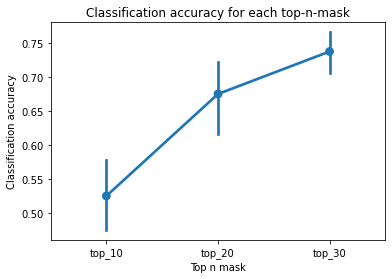

In [12]:
# write a function to extract left-out subject id and the classification acc. 
def extract_clf_acc(base_dir, top_num, num_subjs):
    
    import os
    import numpy as np
    import pandas as pd
    path = os.path.join(base_dir, top_num, 'classify_result.txt')

    # read each line, from which extract the left out subject id and the clf acc
    with open(path, "r") as file:
        lines = file.readlines()
    loo_id = []
    acc = []
    for line in lines: 
        id_start_index = line.index('_no') + len('_no')
        id_end_index = line.index('_result_seq')
        id = int(line[id_start_index:id_end_index])
        loo_id.append(id)

        acc_start_index = line.index(': ') + 2
        acc_end_index = line.index('\n')
        score = float(line[acc_start_index:acc_end_index])
        acc.append(score)

    # write a dataframe   
    colnames = ['loo_id','clf_acc','top_num']
    df = pd.DataFrame(index=range(len(loo_id)), columns=colnames)
    df['loo_id'] = loo_id 
    df['clf_acc'] = acc
    df['top_num'] = np.repeat(top_num, len(loo_id)).tolist()
        
    return df

# generate df and concatenate them together
df_list = [extract_clf_acc(output_dir,'top_10', num_subjs),
           extract_clf_acc(output_dir,'top_20', num_subjs),
           extract_clf_acc(output_dir,'top_30', num_subjs)]
final_df = pd.concat(df_list).reset_index(drop=True)

# a quick look at the df 
ax = sns.pointplot(x="top_num", y="clf_acc", data=final_df)
ax.set_title('Classification accuracy for each top-n-mask')
ax.set_ylabel('Classification accuracy')
ax.set_xlabel('Top n mask')
print("The FCMA classification accuracy when using the functional connectivity pattern of \n voxels within each subject's top n mask to predict the current task condition (A or B) ")

### 3.2 Visualize voxels in top-n-masks <a id="niview"></a>
- Let's take the top 30 voxel results as an example. Remember that the top 30 voxels for each training sets may be different given that we have 8 training sets (one for each left out subject). Thus a given voxel may appear 0 - 8 times in these 8 top-30-feature masks. This can be converted into proportions (what proportion of folds does each voxel end up in the top 30 voxels), resulting a voxelwise map. (i.e., 'prop_top30.nii.gz')
- Let's look at our cherry picked brain again, which consists of 432 voxels in total. The 432 voxels are evenly divided into two 6x6x6 cubes located at vmPFC and precuenus as shown below. 

The cherry-picked 432 voxel brain that consists of two brain regions



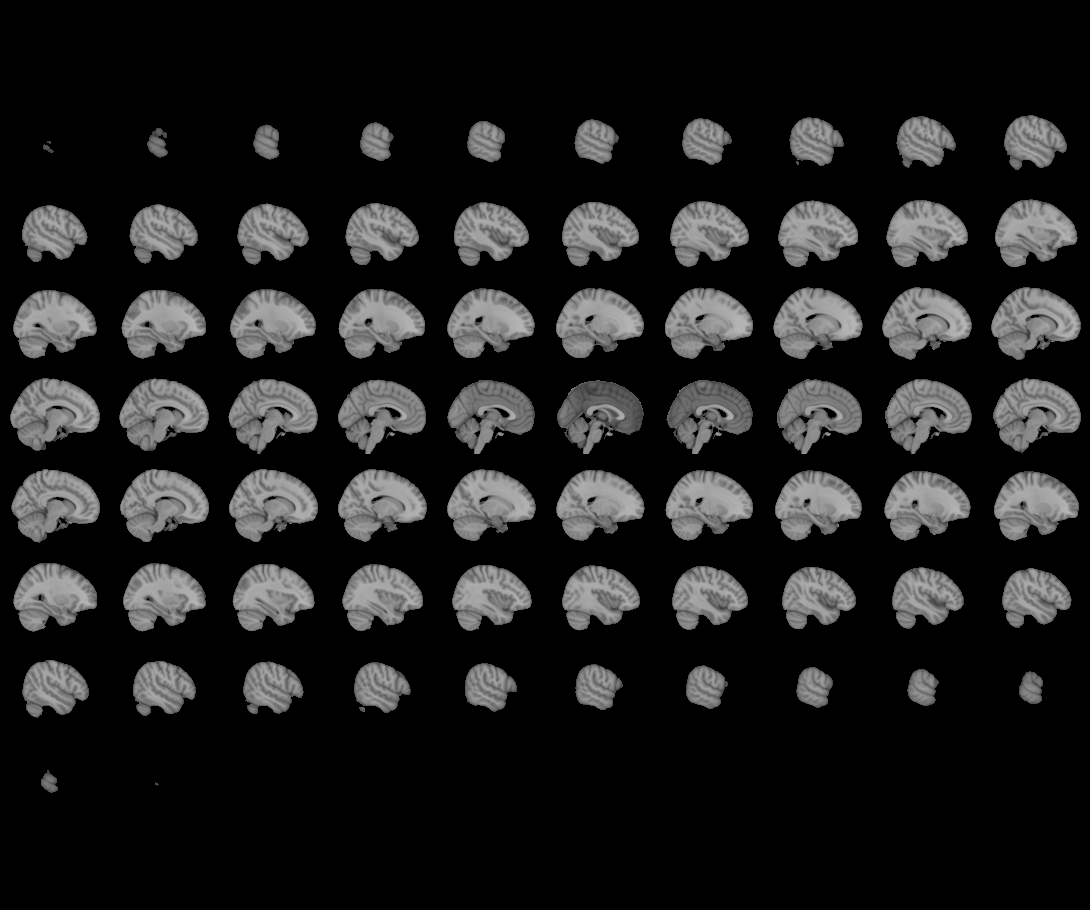
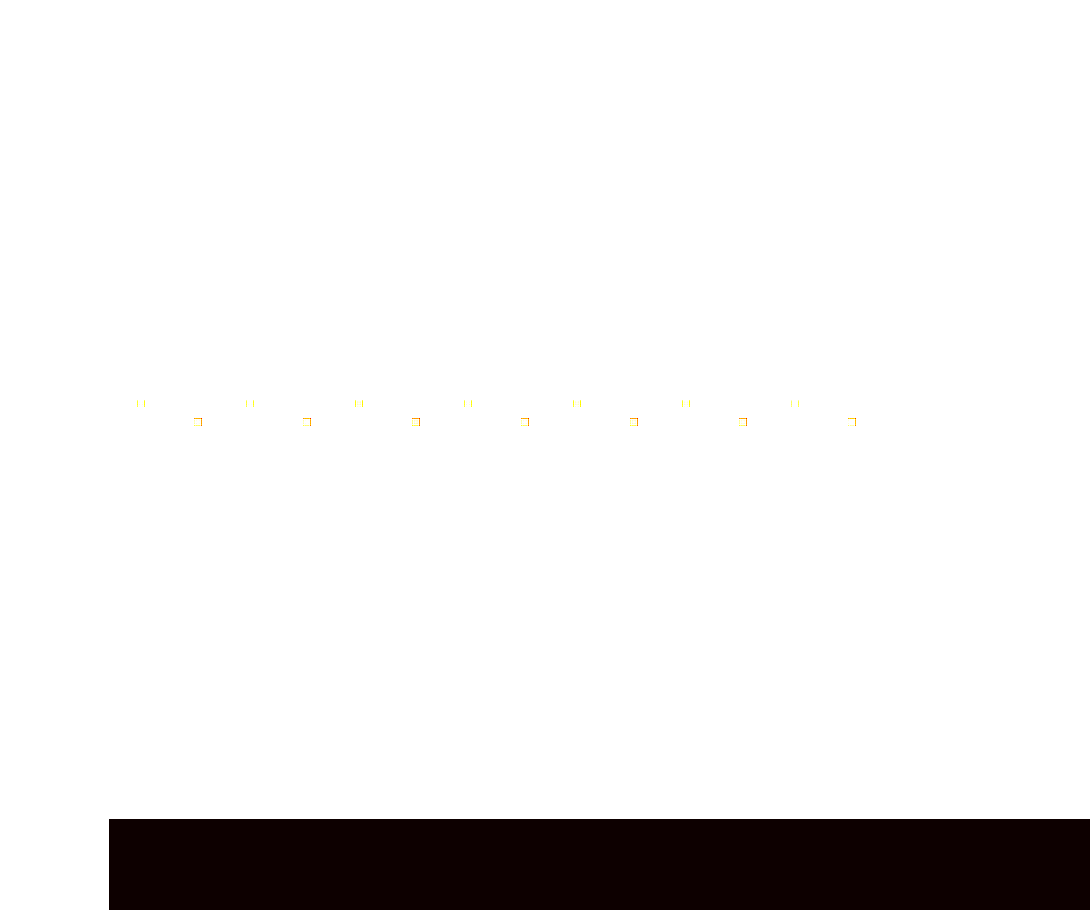

In [13]:
print("The cherry-picked 432 voxel brain that consists of two brain regions")
plotting.view_img(os.path.join(cur_dir, 'sim_info', 'full_mask.nii.gz'), title = "The brain mask", colorbar = False)

- Then we can look at the top 30 voxels. The color bar indicates the proportion of folds a voxel appears in the 8 top-30-masks (one for each subject). 


The top 30 voxels proportion map



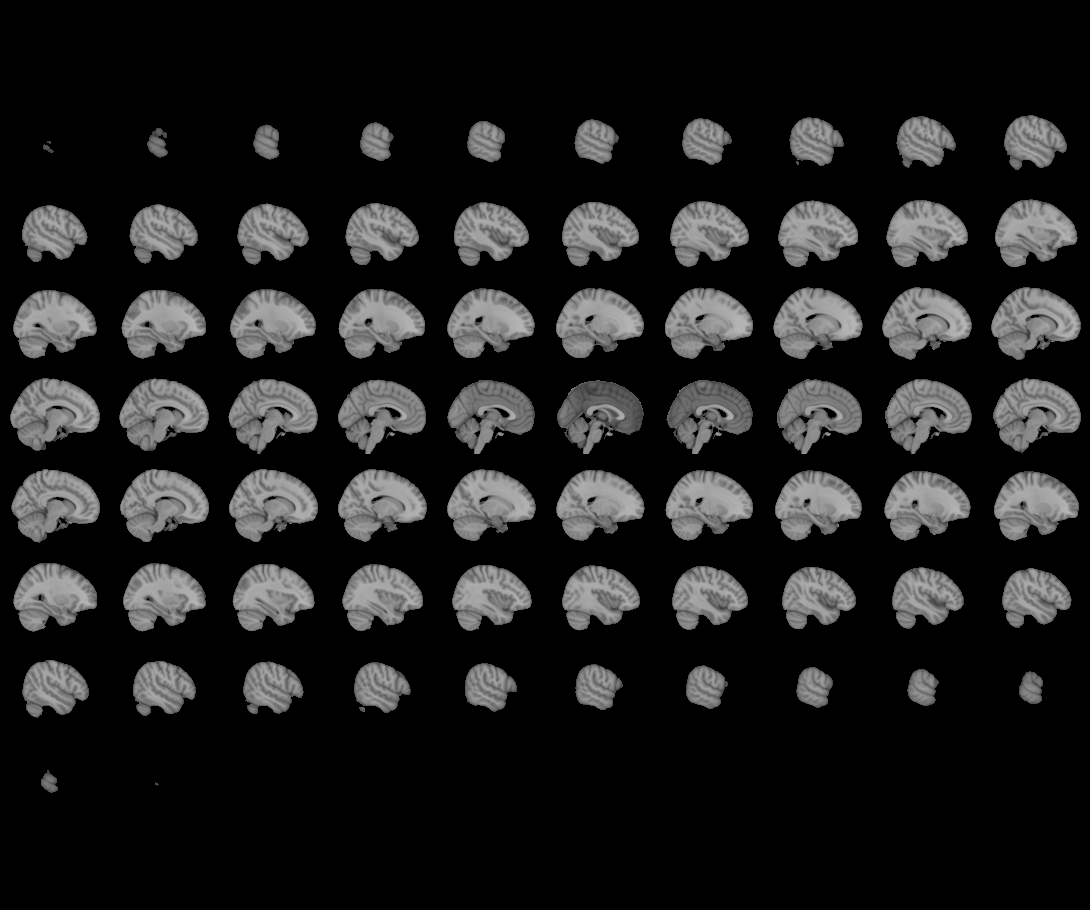
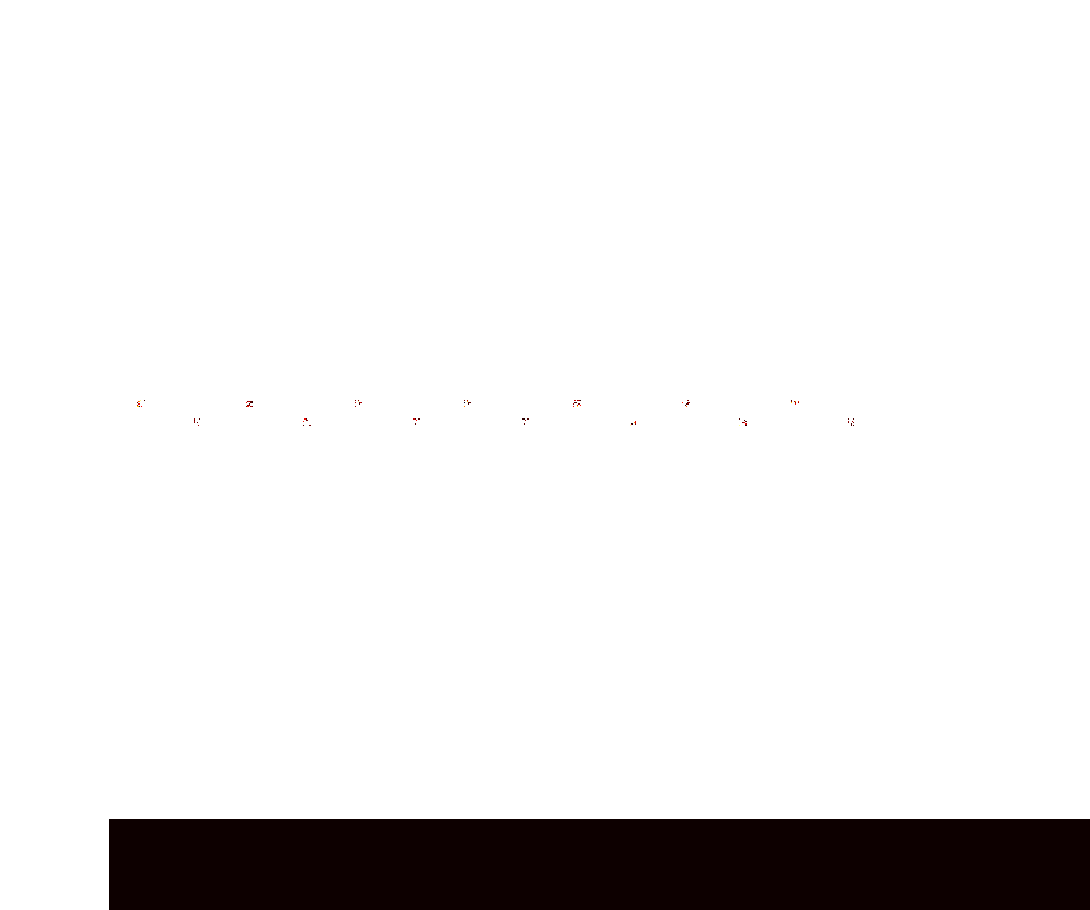

In [14]:
print("The top 30 voxels proportion map")
plotting.view_img(os.path.join(output_dir, 'top_30','prop_top30.nii.gz'), title = "Top 30 voxels")

### 3.3 Visualize functional connectivity pattern with circos plot <a id="circos"></a>
- For a given epoch, we can use circos plot to understand the functional connectivity pattern between our top N voxels. Note that for plotting the circos plot, one would usually be dealing with thousands of voxels, thus knowing how to group voxels beforehand is important. Here for the simulated data, we have two arbitrarily chosen ROIs, and the top n voxels were grouped into one of these two ROIs.

The figure plots all 432 voxels across two ROIs; 
and highlighted how the top 30 voxels are functionally connected, both within and across ROIs.


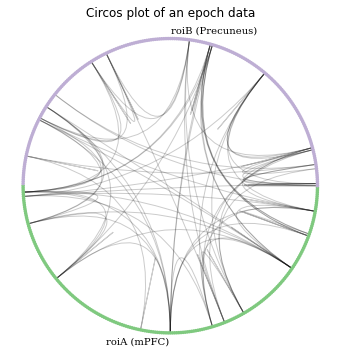

In [16]:
# Load in the data 
epoch_data = raw_data[0] # Just load a single subject and a single epoch
mask_top_n_file = os.path.join(output_dir, 'top_30/fc_no0_result_seq_top30.nii.gz')
mask_top_n_nii = nib.load(mask_top_n_file)  # Load the mask that leaves that participant out
mask_top_n = mask_top_n_nii.get_fdata()

# Convert the top n mask into a vector with the same number of elements as the whole brain
mask_vec = mask.reshape(np.prod(mask.shape))
mask_top_vec = mask_top_n.reshape(np.prod(mask_top_n.shape))[mask_vec]

# Modify the epoch data, for visulization purpose
epoch_data[:,np.where(mask_top_vec==0)] = 1

# Make the data c continguous 
epoch_data_masked = np.ascontiguousarray(epoch_data.T, dtype=np.float32)

# Create the internal correlation
epoch_corr = compute_correlation(epoch_data_masked, epoch_data_masked)

# Load the two simulated ROIs
roiA = nib.load(os.path.join(cur_dir, 'sim_info/ROI_A_mpfc.nii.gz')).get_fdata()
roiB = nib.load(os.path.join(cur_dir, 'sim_info/ROI_B_precuenus.nii.gz')).get_fdata()

# Pull out the coordinates of the mask (in numpy space)
coord_x, coord_y, coord_z = np.where(mask == 1)

# %matplotlib inline

# What is the (absolute) correlation threshold
threshold = 0.8

# Preset the graph
G = nx.Graph()

# Create the edge list
nodelist = []
edgelist = []
for row_counter in range(epoch_corr.shape[0]):
    nodelist.append(str(row_counter))  # Set up the node names
    
    for col_counter in range(epoch_corr.shape[1]):
        
        # Determine whether to include the edge based on whether it exceeds the threshold
        if (abs(epoch_corr[row_counter, col_counter]) > threshold) and (abs(epoch_corr[row_counter, col_counter]) < 1):
            # Add a tuple specifying the voxel pairs being compared and the weight of the edge
            edgelist.append((str(row_counter), str(col_counter), {'weight': epoch_corr[row_counter, col_counter]}))
        
# Create the nodes in the graph
G.add_nodes_from(nodelist)

# Add the edges
G.add_edges_from(edgelist)

for n, d in G.nodes(data=True):
    
    # Is the voxel in roiA or B
    if roiA[coord_x[int(n)],coord_y[int(n)],coord_z[int(n)]] == 1:
        G.nodes[n]['grouping'] = 'roiA (mPFC)'

    elif roiB[coord_x[int(n)],coord_y[int(n)],coord_z[int(n)]] == 1:
        G.nodes[n]['grouping'] = 'roiB (Precuneus)'


c = CircosPlot(graph=G, node_grouping='grouping', node_color='grouping', group_label_position='middle',figsize=(10,6))
c.draw()
plt.title('Circos plot of an epoch data')
print("The figure plots all 432 voxels across two ROIs; \nand highlighted how the top 30 voxels are functionally connected, both within and across ROIs.")

## 4. Summary <a id="sum"></a>
- In the notebook, we have shown how to use FCMA to perform non-seed based, whole brain functional connectivity analyses. Going back to our two initial questions, we asked:
    1. Do functional connectivity patterns differ between condition A and B? 
    2. If so, which brain regions are driving the difference?
- Answering Q1: 
    - Based on the plot in 3.1 above, we can argue the functional connectivity pattern within the top 20 and 30 selected voxels can be used to differentiate whether a subject is doing condition A or B with relatively high accuracy. Thus, the answer to question 1 is yes! The FC patterns do differ across condition A and B.
- Answering Q2:
    - The plot in 3.2 shows where those top n voxels are located and the plot in 3.3 shows how the top n voxels are functionally connected. 
   